In [63]:
import numpy as np
import string
import os
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
import pandas as pd

In [64]:
reviews = "reviews.csv"
data_set = pd.read_csv(reviews)
data_set2 = pd.DataFrame(data_set, columns=['buisness_name','text']) 
data_set.head()




,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [65]:
Text = data_set['text']
buisness_name = data_set['business_name']

preprossed_text = []
stop_words = set(stopwords.words('english'))
stop_words.add('I')
stop_words.add('The')
stop_words.add('it')
st = ISRIStemmer()

for text in Text:
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.split()
    text = [st.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    preprossed_text.append(text)


data = pd.DataFrame({'business_name':buisness_name,'text':preprossed_text})
data.head()


,business_name,text
0,Haci'nin Yeri - Yigit Lokantasi,We went Marmaris wife holiday We chose restaur...
1,Haci'nin Yeri - Yigit Lokantasi,During holiday Marmaris ate fit food Its reall...
2,Haci'nin Yeri - Yigit Lokantasi,Prices affordable menu photo cost 108 liras Yo...
3,Haci'nin Yeri - Yigit Lokantasi,Turkeys cheapest artisan restaurant food delic...
4,Haci'nin Yeri - Yigit Lokantasi,dont know look terms price performance point t...


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [67]:
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(preprossed_text)


query = "waiter is rude"
processed_query = query.translate(str.maketrans('', '', string.punctuation))
processed_query = processed_query.split()
processed_query = [st.stem(word) for word in processed_query if not word in stop_words]
processed_query = ' '.join(processed_query)

query_vector = vectorizer.transform([processed_query])


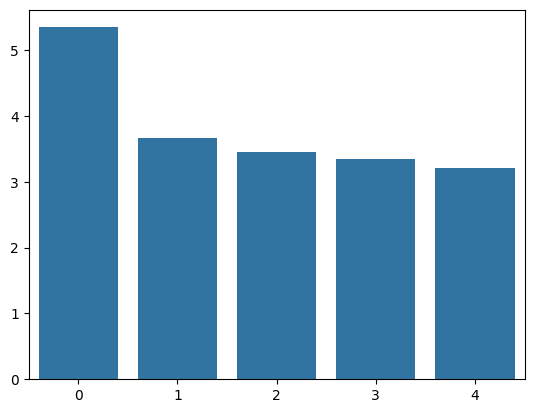

In [68]:
import seaborn as sns
lsa = TruncatedSVD(n_components=5)
lsa.fit(vectorized_data)
lsa_data = lsa.transform(vectorized_data)

lsa_query = lsa.transform(query_vector)
sigma=lsa.singular_values_
sns.barplot(x=list(range(len(sigma))), y=sigma)

similarity = cosine_similarity(lsa_data,lsa_query)


In [69]:
rankings = np.argsort(similarity,axis=0)[::-1]
rankings = rankings.flatten()

output = []
scores = []
buisness_name_sorted = []
ratings_sorted = []
Query = []
origina_review_category = []

for rank in rankings:
    output.append(data_set['text'][rank])
    scores.append(similarity[rank][0])
    buisness_name_sorted.append(data_set['business_name'][rank])
    ratings_sorted.append(data_set['rating'][rank])
    Query.append(query)
    origina_review_category.append(data_set['rating_category'][rank])



print("Top 5 reviews for the query are:")
for i in range(5):
    print(output[i])
    print("Similarity Score: ", scores[i])
    print("\n")

Top 5 reviews for the query are:
The view is great. This may be its only good feature. Apart from that; they have extremely rude employees.
Similarity Score:  0.9512203138197383


Salad was great; appetizers were good. The degree of cooking of the meat was good. Also the toilets were very clean.
Similarity Score:  0.942577449462808


We tried Lahmacun and Beyti. They both taste great.
Similarity Score:  0.9422158910895646


Everything was amazing; thank you Yesemek! I ate yuvarlama and mumbar.
Similarity Score:  0.926058130237372


Great tastes; the interest of the employees was very good; thank you to them.
Similarity Score:  0.9254785869415794




In [70]:
final_data = pd.DataFrame({'buisness_name':buisness_name_sorted,'text':output,'score':scores,'rating':ratings_sorted ,'Query':Query ,'original_review_category':origina_review_category})
final_data.head()

,buisness_name,text,score,rating,Query,original_review_category
0,Koco Restaurant,The view is great. This may be its only good f...,0.951220,1,waiter is rude,menu
1,Sini Mugla,Salad was great; appetizers were good. The deg...,0.942577,4,waiter is rude,taste
2,Diyarbakir Ocakbasi Palace,We tried Lahmacun and Beyti. They both taste g...,0.942216,4,waiter is rude,taste
3,Yesemek,Everything was amazing; thank you Yesemek! I a...,0.926058,5,waiter is rude,indoor_atmosphere
4,Kukis Suadiye,Great tastes; the interest of the employees wa...,0.925479,5,waiter is rude,outdoor_atmosphere


In [71]:
words_topic_matrix = pd.DataFrame(lsa.components_,index=['topic1','topic2','topic3','topic4','topic5'],columns=vectorizer.get_feature_names_out())

#classifying most relevent words for each topic
top_words = []
for i in range(5):

    top_words.append(words_topic_matrix.loc['topic'+str(i+1)].sort_values(ascending=False)[0:10])

# Function to concatenate words of each topic
def concatenate_words(topics):
    concatenated_strings = []
    for topic in topics:
        concatenated_strings.append(' '.join(topic.index))
    return concatenated_strings

# Generate the concatenated strings
concatenated_strings = concatenate_words(top_words)

# Print the results
for i, string in enumerate(concatenated_strings):
    print(f"Topic {i+1}: {string}")




Topic 1: good delicious place nice food service prices great taste it
Topic 2: great ambiance service recommend thanks thank dishes food everything appetizers
Topic 3: delicious food reasonable staff friendly fast prices recommend fresh quite
Topic 4: expensive place nice ambiance it beautiful crowded clean amazing view
Topic 5: prices high recommend expensive reasonable nice little bit flavors amazing


In [72]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [73]:

# Create a dictionary and corpus
dictionary = corpora.Dictionary([review.split() for review in preprossed_text])
corpus = [dictionary.doc2bow(review.split()) for review in preprossed_text]

# Build LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")


Topic: 0 
Words: 0.028*"good" + 0.021*"place" + 0.019*"food" + 0.018*"delicious" + 0.016*"nice" + 0.015*"service" + 0.013*"taste" + 0.012*"It" + 0.008*"price" + 0.008*"employees"
Topic: 1 
Words: 0.022*"It" + 0.021*"We" + 0.020*"good" + 0.014*"delicious" + 0.011*"nice" + 0.011*"place" + 0.007*"ate" + 0.007*"breakfast" + 0.006*"really" + 0.006*"service"
Topic: 2 
Words: 0.013*"place" + 0.009*"order" + 0.008*"prices" + 0.008*"food" + 0.008*"came" + 0.008*"We" + 0.008*"It" + 0.007*"hamburger" + 0.007*"good" + 0.006*"menu"
Topic: 3 
Words: 0.021*"good" + 0.018*"place" + 0.011*"eat" + 0.011*"It" + 0.010*"taste" + 0.010*"bad" + 0.009*"much" + 0.008*"delicious" + 0.007*"nice" + 0.006*"food"
Topic: 4 
Words: 0.020*"place" + 0.017*"taste" + 0.016*"delicious" + 0.012*"good" + 0.011*"nice" + 0.010*"We" + 0.010*"Its" + 0.010*"really" + 0.009*"like" + 0.008*"service"


In [74]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sid.polarity_scores(text)
    return 'positive' if scores['compound'] >= 0.05 else 'negative' if scores['compound'] <= -0.05 else 'neutral'

review_sentiments = [get_sentiment(review) for review in preprossed_text]
print(review_sentiments)


['negative', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'negative', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', '

In [75]:
final_data = pd.DataFrame({'buisness_name':buisness_name_sorted,'text':output,'score':scores,'rating':ratings_sorted ,'Query':Query, 'review_sentiment':review_sentiments ,'original_review_category':origina_review_category})
final_data.head()

,buisness_name,text,score,rating,Query,review_sentiment,original_review_category
0,Koco Restaurant,The view is great. This may be its only good f...,0.951220,1,waiter is rude,negative,menu
1,Sini Mugla,Salad was great; appetizers were good. The deg...,0.942577,4,waiter is rude,positive,taste
2,Diyarbakir Ocakbasi Palace,We tried Lahmacun and Beyti. They both taste g...,0.942216,4,waiter is rude,positive,taste
3,Yesemek,Everything was amazing; thank you Yesemek! I a...,0.926058,5,waiter is rude,positive,indoor_atmosphere
4,Kukis Suadiye,Great tastes; the interest of the employees wa...,0.925479,5,waiter is rude,neutral,outdoor_atmosphere


In [76]:
import pandas as pd

# Combine reviews, topics, and sentiments
review_data = {
    'review': [review for review in output],
    'processed_review': preprossed_text,
    'sentiment': review_sentiments,
    'topics': [lda_model[dictionary.doc2bow(review.split())] for review in preprossed_text]
}

df = pd.DataFrame(review_data)

# Example visualization with word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_topics = ' '.join([word for review in df['processed_review'] for word in review.split()])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_topics)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

# Supervised approach

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
